In [139]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py
import numpy as np
import time
import math
import os
import json
from pathlib import Path
from tmm_acc import coh_tmm_normal_spol_spec_d
from arch.HybridNet import HybridNet, HybnetLoss
import yaml
import re

logpattern = r"^[\D\s:]+(\d+)\s\|[\D\s:]+([\d.]+)\s\|[\D\s:]+([\d.]+)"

# pyplot 中文显示宋体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = True

dtype = torch.float
device_data = torch.device('cpu')
device_test = torch.device('cuda:0')
# evaluate the model by calculating the MSE of each curve
def evaluate(model, Input, Output):
    model.eval()
    with torch.no_grad():
        Output_pred = model(Input)
        loss_mat = (Output_pred - Output) ** 2
        loss = torch.mean(loss_mat, dim=1)
        return loss.cpu().numpy(), Output_pred.cpu().numpy()
    
dictionary = scio.loadmat(r'data/Data_merged_Comp_50_K_10_Iter_150.mat')['Dictionary']
dictionary = torch.from_numpy(dictionary).float()

def mutual_coh(responses):
    r = torch.from_numpy(responses).float()
    D = torch.matmul(r, dictionary)
    # D = responses
    D = D / torch.norm(D, dim=(0,1))
    gram = torch.matmul(D.T, D)

    # 平均不相关性 (~0.193)
    rloss = torch.mean((gram - torch.eye(gram.size(0), device=gram.device))**2)

    rlossm = torch.max((gram - torch.eye(gram.size(0), device=gram.device))**2)
    return rloss.detach().cpu().numpy(), rlossm.detach().cpu().numpy()


In [174]:
model_folder = Path(r'D:\zf-py\graduate2\PCSED\nets\hybnet\细微差异初始\平均不相关性\20240224_153230')
# model_folder = Path(r'D:\zf-py\graduate2\PCSED\nets\hybnet\TMM+稀疏不相关性+DNN\20240221_231347')

# model_folder = Path(r'D:\zf-py\graduate2\PCSED\nets\hybnet\细微差异初始\原版\20240224_100532')
# model_folder = Path(r'D:\zf-py\graduate2\PCSED\nets\hybnet\TMM+DNN\20240223_095146')
# model_folder = Path(r"D:\zf-py\graduate2\PCSED\nets\hybnet\20240229_112045_PCSED++")

# with open(model_folder/'config.json',encoding='utf-8') as f:
#     config = json.load(f)

with open(model_folder/'config.yml',encoding='utf-8') as f:
    config = yaml.load(f,Loader=yaml.FullLoader)

fnet_cfg = config['fnet']
PCSED_cfg = config['PCSED']
TFNum = PCSED_cfg['TFNum']

epoch = []
train_loss = []
test_loss = []

with open(model_folder/ 'TrainingLog.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'Epoch' in line:
            match = re.match(logpattern, line)
            epoch.append(int(match.group(1)))
            train_loss.append(float(match.group(2)))
            test_loss.append(float(match.group(3)))

WL = np.arange(fnet_cfg['StartWL'], fnet_cfg['EndWL'], fnet_cfg['Resolution'])

params = scio.loadmat(model_folder/'TrainedParams.mat')['Params']
TargetCurves = scio.loadmat(model_folder/'TargetCurves.mat')['TargetCurves']
TargetCurves_FMN = scio.loadmat(model_folder/'TargetCurves_FMN.mat')['TargetCurves_FMN']
n_array = scio.loadmat(r'D:\zf-py\graduate2\code\coatings\n_L20_R5.0.mat')['n']


model:HybridNet = torch.load(model_folder/'hybnet.pkl')

fnet = model.fnet
print(f'{min(test_loss):.5f}')

0.00014


In [112]:
_s = train_loss

In [111]:
_r = train_loss

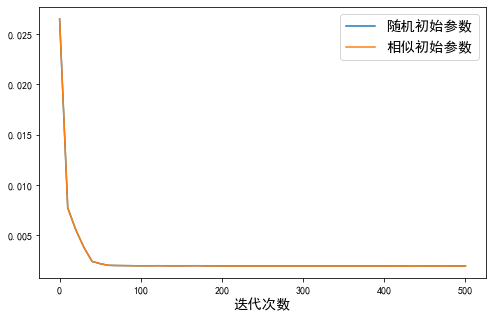

In [113]:
plt.figure(figsize=(8,5))
plt.plot(epoch, _r, label='随机初始参数')
plt.plot(epoch, _s, label='相似初始参数')
plt.xlabel('迭代次数',fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

In [166]:
SpectralSliceNum = WL.size
# LightMat = scio.loadmat(PCSED_cfg['LightPath'])['data']
# LightMat[2] -= LightMat[2].min()
# LightMat -= LightMat.min(axis=0)
# LightMat /= LightMat.max(axis=0)
LightMat = np.ones([1, SpectralSliceNum], dtype=np.float32)
LightNum = LightMat.shape[0]

TestingDataSize = PCSED_cfg['TestingDataSize']
Specs_test = torch.zeros([TestingDataSize * LightNum, SpectralSliceNum], device=device_test, dtype=dtype)
LightMat = torch.tensor(LightMat, device=device_test, dtype=dtype)
data = scio.loadmat(PCSED_cfg['TestDataPath'])
Specs_all = np.array(data['data'])
TestingDataSize = min(TestingDataSize, Specs_all.shape[0])
np.random.shuffle(Specs_all)
Specs_all = torch.tensor(Specs_all[0:TestingDataSize, :], device=device_test)
for i in range(LightNum):
    Specs_test[i * TestingDataSize: (i + 1) * TestingDataSize, :] = Specs_all * LightMat[i, :]

print('TestingDataSize:', TestingDataSize)
print('LightNum:', LightNum)

TestingDataSize: 10000
LightNum: 1


In [175]:
from test_hybnet import eval_hybnet
loss, pred = eval_hybnet(model, Specs_test, model.show_hw_weights())
print(loss.mean())

0.00013753175


In [ ]:
input_test = 

eval_loss, eval_pred = evaluate(model, , Specs_test)

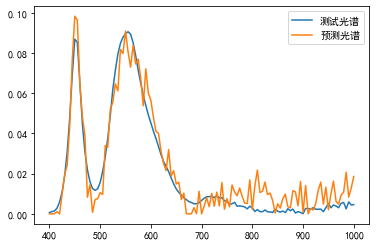

In [69]:
plt.plot(WL, Specs_test[14000].cpu().numpy(), label='测试光谱')
pred = model(Specs_test[14000].unsqueeze(0))
plt.plot(WL, pred.cpu().detach().numpy().squeeze(), label='预测光谱')
plt.legend()
plt.show()

In [4]:
params = scio.loadmat(model_folder/'TrainedParams.mat')['Params']
TargetCurves = scio.loadmat(model_folder/'TargetCurves.mat')['TargetCurves']
TargetCurves_FMN = scio.loadmat(model_folder/'TargetCurves_FMN.mat')['TargetCurves_FMN']
n_array = scio.loadmat(r'D:\zf-py\graduate2\code\coatings\n_L20_R5.0.mat')['n']


In [23]:
d_array = np.zeros((params.shape[0],params.shape[1]+2))
d_array += np.inf
d_array[:,1:-1] = params

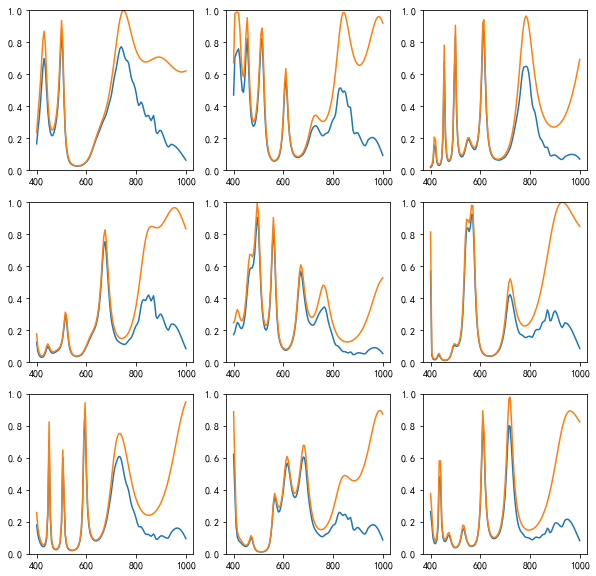

In [5]:
plt.figure(figsize=(10, 10))
for i in range(TFNum):
    plt.subplot(math.ceil(math.sqrt(TFNum)), math.ceil(math.sqrt(TFNum)), i + 1)
    plt.plot(WL, TargetCurves[i, :])
    plt.plot(WL, TargetCurves_FMN[i, :])
    # plt.plot(WL, T[i, :])
    plt.ylim(0, 1)
plt.show()

In [153]:
params_history = scio.loadmat(model_folder/r'params_history.mat')['params_history']
params_history = params_history.transpose(1,0,2)
params_history.shape

(9, 52, 20)

C:\Users\Nightsky\AppData\Local\Temp\ipykernel_52240\2120750452.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


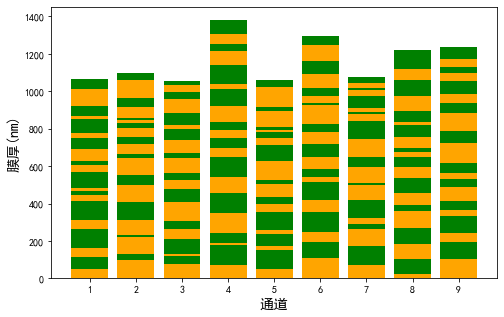

In [133]:
n_TF = params_history.shape[0]
n_layers = params_history.shape[2]

# plot the final params using stacked bar

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
bottom = np.zeros(n_TF)
for i in range(n_layers):
    color = 'g' if i%2 else 'orange'
    ax.bar(np.arange(1,n_TF+1), params_history[:,0,i], bottom=bottom, color=color)
    bottom += params_history[:,0,i]
# fig.savefig(model_folder/'params.png')
ax.set_xticks(np.arange(1,n_TF+1))
ax.set_xlabel('通道',fontsize='x-large')
ax.set_ylabel('膜厚(nm)',fontsize='x-large')
fig.show()

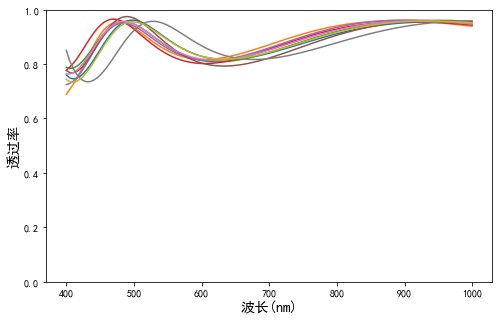

平均不相关性: (array(0.01959836, dtype=float32), array(0.99994755, dtype=float32))


In [155]:
p = params_history[:,0,:]
fnet.to(device_test)
response = fnet(torch.from_numpy(p).float().to(device_test)).detach().cpu().numpy()
plt.figure(figsize=(8, 5))
for i in range(TFNum):
    plt.plot(WL,response[i])
plt.ylim(0,1)
plt.xlabel('波长(nm)', fontsize='x-large')
plt.ylabel('透过率', fontsize='x-large')
plt.show()
print('平均不相关性:', mutual_coh(response))

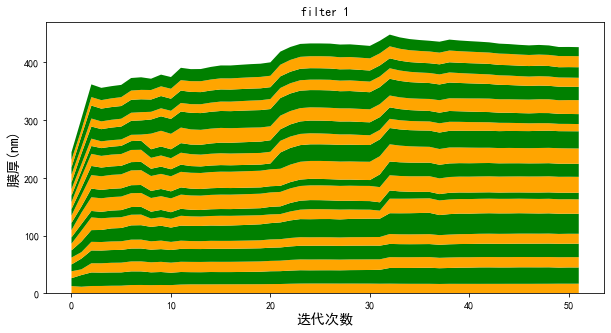

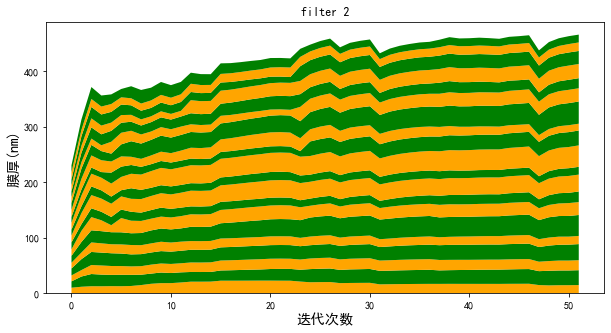

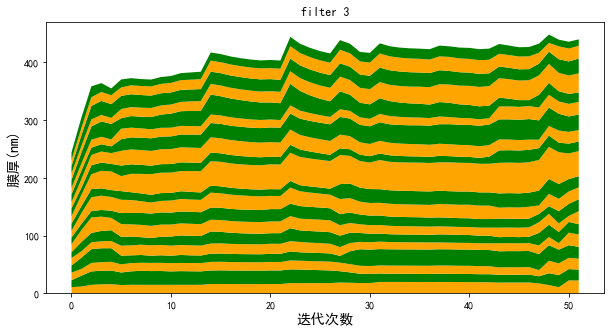

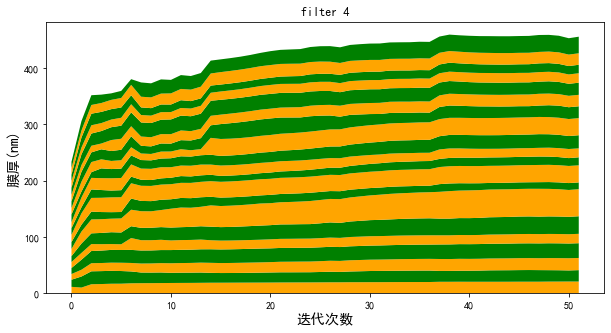

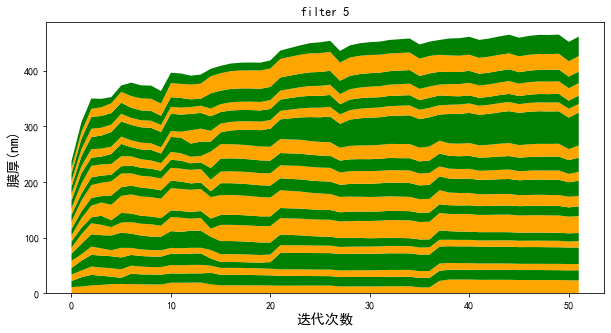

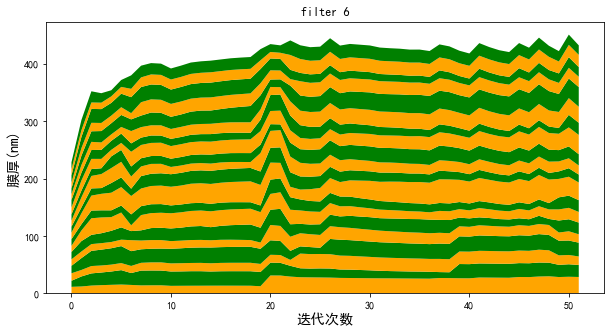

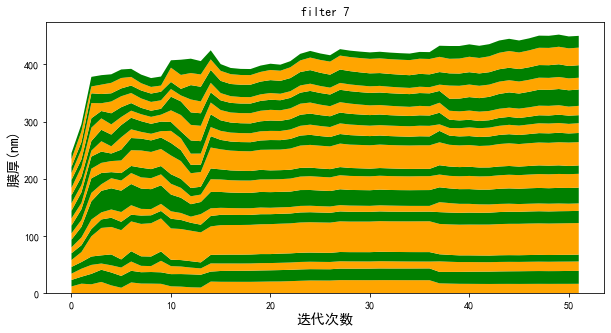

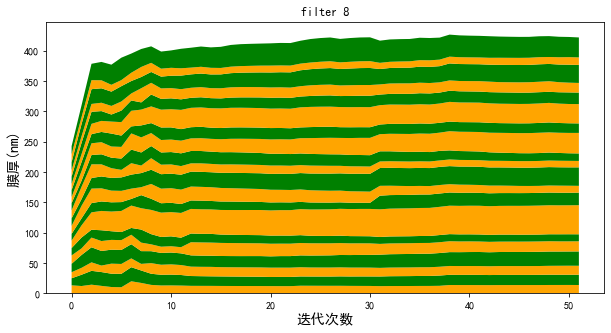

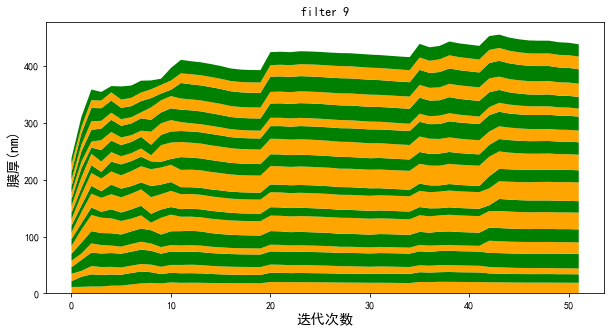

In [29]:
n_TF = params_history.shape[0]

for fidx, params in enumerate(params_history[:,:200,:]):
    plt.figure(figsize=(10, 5))

    c,l=[],[]
    for layer in range(params.shape[1]):
        color = 'g' if layer%2 else 'orange'
        c.append(color)
        l.append(params[:,layer])

    plt.stackplot(np.arange(params.shape[0]),*l,colors=c)
    plt.title(f'filter {fidx+1}')
    plt.xlabel('迭代次数', fontsize='x-large')
    plt.ylabel('膜厚(nm)', fontsize='x-large')
    plt.show()


In [21]:
if params is None:
    pass

In [ ]:
params[:,::1]

array([[314.40863 ,  42.896194, 185.1375  , ..., 332.26767 , 164.1332  ,
        162.42085 ],
       [317.09592 ,  46.36975 , 188.28275 , ..., 337.56818 , 163.71745 ,
        163.83932 ],
       [318.92236 ,  44.511578, 185.03775 , ..., 333.84286 , 160.83492 ,
        167.46713 ],
       ...,
       [318.82135 ,  58.99784 , 244.43875 , ..., 307.04352 ,  92.79601 ,
        163.23233 ],
       [318.79135 ,  59.022987, 244.373   , ..., 306.84613 ,  92.72938 ,
        163.12085 ],
       [318.8381  ,  59.08129 , 244.33667 , ..., 306.82025 ,  92.7093  ,
        162.99657 ]], dtype=float32)

In [ ]:
dict = scio.loadmat(r'data\Data_merged_Comp_50_K_10_Iter_150.mat')['Dictionary']

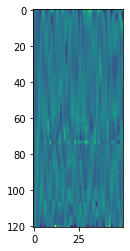

In [ ]:
plt.imshow(dict)